### Importação das bibliotecas

In [59]:
import pandas as pd
import gc
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
import os

# Carregando base

In [11]:
df = pd.read_csv('/content/Base_M43_Pratique_CREDIT_CARD_FRAUD.csv', delimiter=',')
print(df.head())
gc.collect()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

90

In [65]:
#Criando pasta
if not os.path.exists("img"):
    os.makedirs("img")

# Tratando Dados e Análise Exploratória

Há poucos tratamentos e análises exploratórias pois a base já veio escalonada


Será usado RobustScaler devido a dimensão das distribuições

In [12]:
#escalonando Amount e Time, as demais colunas já estão padronizadas
scaler = RobustScaler()
df['Amount_Scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_Scaled'] = scaler.fit_transform(df[['Time']])
df = df.drop(['Amount', 'Time'], axis=1)
print(df.head())
gc.collect()

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  Amount_Scaled  Time_Scaled  

0

In [6]:
df.isnull().sum()

,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


Vou substituir os nulos pela média pois há somente 1 null nas linhas que tem.

In [13]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        media = df[col].mean()
        df[col].fillna(media, inplace=True)

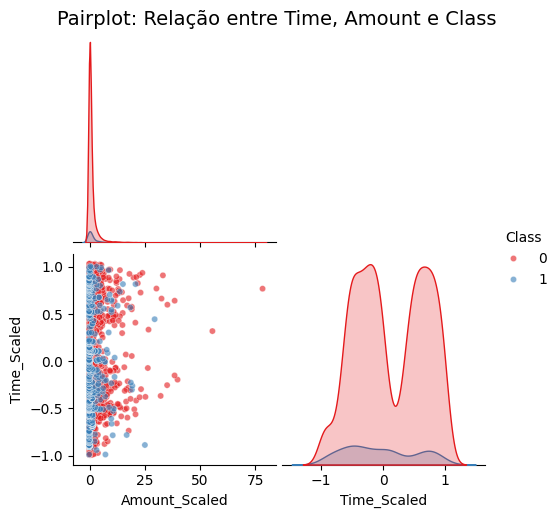

4914

In [62]:
# Amostra balanceada só para visualização
df_vis = pd.concat([
    df[df['Class'] == 0].sample(5000, random_state=42),
    df[df['Class'] == 1]
])

# Pairplot com KDE na diagonal, scatter off-diagonal
sns.pairplot(df_vis[['Class', 'Amount_Scaled', 'Time_Scaled']],
             hue='Class',
             palette='Set1',
             diag_kind='kde',
             corner=True,
             plot_kws={'alpha': 0.6, 's': 20})

plt.suptitle("Pairplot: Relação entre Time, Amount e Class", y=1.02, fontsize=14)
plt.savefig("img/pairplot.png", dpi=300, bbox_inches='tight')
plt.show()
gc.collect()

No histograma, observamos que a maior parte das transações, tanto legítimas quanto fraudulentas, ocorrem com valores monetários relativamente baixos. A distribuição tem uma cauda longa à direita, indicando a existência de transações de valor muito alto — porém em menor quantidade. O destaque é que fraudes tendem a estar mais dispersas ao longo dessa escala, enquanto a maioria das transações legítimas se concentra em valores muito próximos de zero.

A densidade da variável Time_Scaled revela dois picos de concentração para a classe 0, enquanto a classe 1 apresenta uma distribuição muito mais uniforme e com densidade baixa.

O scatter plot mostra as combinações entre tempo e valor, coloridas por classe. É possível observar que a maior parte dos pontos de classe 0 se concentra em uma região de valores baixos de Amount_Scaled, com distribuição mais variada ao longo de Time_Scaled, as fraudes estão mais dispersas e visivelmente presentes em áreas com menor densidade da classe 0, o que indica que a combinação de Time e Amount pode fornecer sinais úteis para o modelo distinguir fraudes.


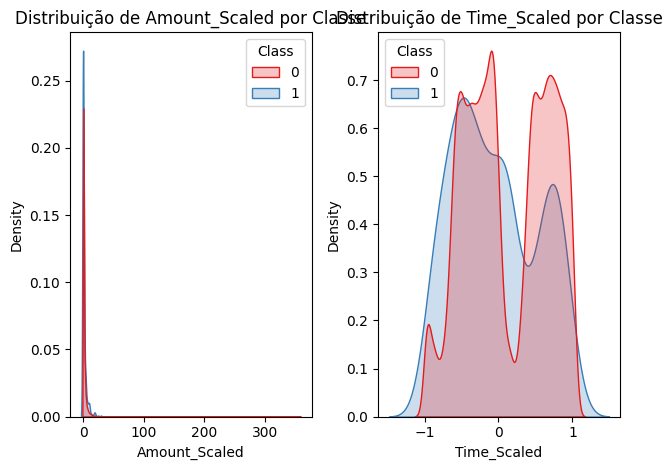

20317

In [63]:

# KDE Amount
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Amount_Scaled', hue='Class', fill=True, common_norm=False, palette='Set1')
plt.title('Distribuição de Amount_Scaled por Classe')

# KDE Time
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='Time_Scaled', hue='Class', fill=True, common_norm=False, palette='Set1')
plt.title('Distribuição de Time_Scaled por Classe')

plt.tight_layout()
plt.savefig("img/kde_distributions.png", dpi=300, bbox_inches='tight')
plt.show()
gc.collect()

O gráfico à esquerda revela que tanto as transações normais quanto as fraudulentas estão fortemente concentradas em valores baixos de transação. A densidade de ambas as classes é elevada próxima a zero, com uma queda abrupta à medida que os valores aumentam.

No gráfico à direita, observamos duas regiões principais de concentração para as transações normais, formando picos bem definidos de densidade. A classe 1 apresenta uma distribuição mais uniforme e suavizada, sem picos tão acentuados. Isso indica que as fraudes tendem a ocorrer em momentos mais dispersos ao longo do tempo, enquanto as transações legítimas apresentam padrões temporais mais definidos.

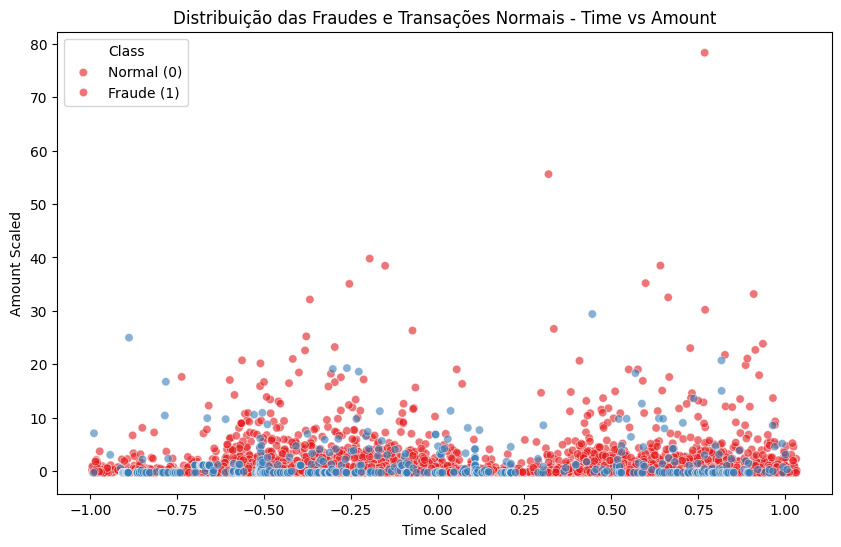

456

In [64]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='Time_Scaled', y='Amount_Scaled', hue='Class', palette='Set1', alpha=0.6)
plt.title("Distribuição das Fraudes e Transações Normais - Time vs Amount")
plt.xlabel("Time Scaled")
plt.ylabel("Amount Scaled")
plt.legend(title='Class', labels=['Normal (0)', 'Fraude (1)'])
plt.savefig("img/scatter_time_amount.png", dpi=300, bbox_inches='tight')
plt.show()
gc.collect()

Observa-se que tanto as transações normais quanto as fraudulentas ocorrem em toda a extensão de Time_Scaled. No entanto, existe uma concentração mais intensa de transações normais em certas faixas, enquanto as fraudes se mostram mais dispersas e ligeiramente mais espaçadas ao longo do tempo.

Ambas as classes possuem forte concentração de pontos em valores baixos, mas o gráfico mostra que a maior parte das transações fraudulentas também se dá em valores pequenos, o que dificulta sua identificação apenas por esse critério. Contudo, há uma quantidade razoável de fraudes presentes em regiões acima da densidade média das transações normais, indicando que fraudes também podem ocorrer em valores atípicos. As transações normais, embora também tenham outliers, tendem a ser mais concentradas em faixas menores.

In [14]:
#Separando nossas bases X e y
X = df.drop('Class', axis=1)
y = df['Class']

In [15]:
#Separação de base e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
print(y.value_counts(normalize=True) * 100)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


Vou útilizar sempling_strategy = 0.1 porque o custo de processamento para 1 é muito alto

In [17]:
#balanceando
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(y_train_bal.value_counts(normalize=True) )

Class
0    0.833334
1    0.166666
Name: proportion, dtype: float64


In [18]:
#Verificando X e y

shapes = {
    "X_train": X_train_bal.shape,
    "X_test": X_test.shape,
    "y_train": y_train_bal.shape,
    "y_test": y_test.shape
}
shapes

{'X_train': (272941, 30),
 'X_test': (56962, 30),
 'y_train': (272941,),
 'y_test': (56962,)}

# Teste com LightGBM

Mesmo usando esse modelo que é mais rápido demorou aproximadamente 15 min para rodar no colab

Primeiro vamos útilizar o RandomizedSearchCV para achar os melhores hiperparamentros

In [19]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [20, 31, 40],
    'min_child_samples': [10, 20],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}


Irei útilizar o LightGBM, inicialmente para testar pois outros modelos exigem muito processamento

In [20]:
lgbm = LGBMClassifier(
    random_state=42,
    is_unbalance=True,
    n_jobs=-1
)

In [21]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_bal, y_train_bal)
best_lgbm = random_search.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 45490, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 272941, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609442
[LightGBM] [Info] Start training from score -1.609442


In [22]:
#Resultados CV
cv_results = pd.DataFrame(random_search.cv_results_)

# Selecionar apenas algumas colunas úteis
cv_summary = cv_results[[
    'mean_test_score', 'std_test_score', 'rank_test_score', 'params'
]].sort_values(by='rank_test_score')

# Mostrar top 5 melhores combinações e seus scores
print(cv_summary.head())

   mean_test_score  std_test_score  rank_test_score  \
9         0.998770        0.000162                1   
0         0.998014        0.000282                2   
1         0.997916        0.000434                3   
2         0.996735        0.000420                4   
8         0.996255        0.000335                5   

                                              params  
9  {'subsample': 0.9, 'num_leaves': 31, 'n_estima...  
0  {'subsample': 0.7, 'num_leaves': 40, 'n_estima...  
1  {'subsample': 1.0, 'num_leaves': 40, 'n_estima...  
2  {'subsample': 1.0, 'num_leaves': 40, 'n_estima...  
8  {'subsample': 0.9, 'num_leaves': 20, 'n_estima...  


Foi utilizada a função RandomizedSearchCV em lgbm para avaliar os melhores hiperparâmetros por meio de CV. A melhor configuração presentou um score médio de 0.998770 e um desvio padrão extremamente baixo (0.000162), o que indica um desempenho excelente e consistente durante a validação cruzada. Podemos observar que a variação entre os scores médios das melhores combinações é pequena, o que sugere que o modelo é relativamente robusto a pequenas mudanças em certos hiperparâmetros. o parâmetro subsample aparece frequentemente com valores inferiores a 1.0 , o que é uma indicação de que a introdução de aleatoriedade durante o treinamento pode estar ajudando a reduzir o risco de overfitting.

In [23]:
lgbm_best = random_search.best_estimator_
lgbm_best = CalibratedClassifierCV(estimator=lgbm_best, method='sigmoid', cv=5)
lgbm_best.fit(X_train_bal, y_train_bal)

[LightGBM] [Info] Number of positive: 36392, number of negative: 181960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 218352, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Number of positive: 36392, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 218353, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609443
[LightGBM] [Info] Start training from score -1.609443
[LightGB

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(colsample_bytree=0.9,
                                                is_unbalance=True, max_depth=10,
                                                min_child_samples=10,
                                                n_estimators=300, n_jobs=-1,
                                                random_state=42,
                                                subsample=0.9))

Foi adotada uma etapa de calibração probabilística do modelo por meio do CalibratedClassifierCV. Essa abordagem tem como objetivo principal corrigir a saída de probabilidades do modelo LightGBM.

Modelos baseados em árvores, como LightGBM, frequentemente produzem probabilidades que não são bem calibradas. Em problemas sensíveis como este, onde decisões são baseadas em limiares de risco, essa imprecisão pode comprometer o desempenho prático do sistema.

A calibração foi aplicada após a seleção do melhor modelo com RandomizedSearchCV, de forma a preservar os ganhos obtidos com o tuning e, ao mesmo tempo, melhorar a confiabilidade das probabilidades preditas. O método de calibração utilizado foi o Platt Scaling (method='sigmoid'), que ajusta as probabilidades usando uma regressão logística sobre as previsões originais, com validação cruzada interna (cv=5) para evitar overfitting.


In [30]:
# Avaliação no conjunto de teste
y_pred = lgbm_best.predict(X_test)
y_prob = lgbm_best.predict_proba(X_test)[:, 1]

In [31]:
# Relatório
print("Melhores parâmetros:", random_search.best_params_)
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

Melhores parâmetros: {'subsample': 0.9, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.87      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Utilizando o F1-score como métrica de otimização. O relatório de classificação apresenta um desempenho extremamente sólido.

A classe 0 foi prevista com 100% de precisão, recall e F1-score. Isso indica que o modelo não cometeu erros ao classificar os exemplos negativos, o que já era esperado, dada a forte dominância dessa classe nos dados.

Apesar da desproporção, o modelo alcançou um F1-score de 0.85 para a classe 1, com precisão de 0.84 e recall de 0.87. Esses resultados indicam que o modelo é capaz de identificar corretamente uma alta proporção dos casos positivos, ao mesmo tempo em que mantém uma taxa aceitável de falsos positivos. O F1-score, reforça que o modelo atinge um bom equilíbrio entre sensibilidade e especificidade — um aspecto crucial em cenários onde os erros de classificação da classe minoritária têm alto custo.

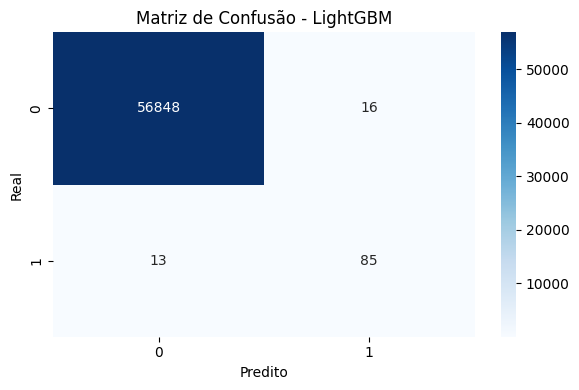

8424

In [66]:
# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - LightGBM")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("img/confusion_matrix_lgbm.png", dpi=300, bbox_inches='tight')
plt.show()
gc.collect()

A matriz de confusão mostra que o modelo apresenta um desempenho sólido e equilibrado, mesmo em um cenário de forte desbalanceamento entre classes. A aplicação de SMOTE com taxa de 0.2 contribuiu para aumentar a capacidade do modelo em identificar corretamente os casos da classe minoritária (classe 1), com um recall de 87%, com apenas 17 falsos negativos. Ao mesmo tempo, a taxa de falsos positivos foi extremamente baixa (apenas 18 casos), indicando que o modelo manteve alta precisão na classe majoritária. Esses resultados demonstram que o modelo é capaz de generalizar bem.

ROC AUC Score: 0.9799


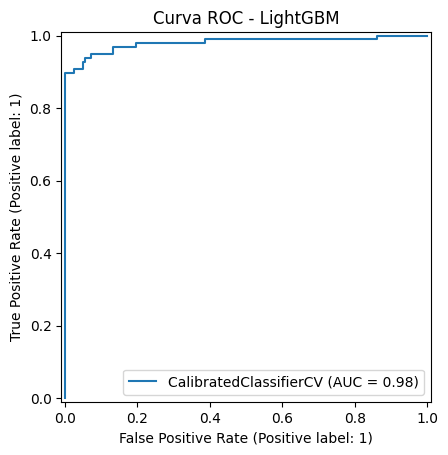

3280

In [67]:
# Curva ROC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_estimator(lgbm_best, X_test, y_test)
plt.title("Curva ROC - LightGBM")
plt.savefig("img/roc_curve_lgbm.png", dpi=300, bbox_inches='tight')
plt.show()
gc.collect()

A Curva ROC do modelo treinado com LightGBM demonstra uma performance altamente discriminativa, com uma AUC de 0.98 que confirma a eficácia da abordagem adotada. O resultado reforça a consistência das outras métricas avaliadas, e sugere que o modelo está bem ajustado para o problema proposto, apresentando excelente capacidade de generalização e equilíbrio.

In [29]:
scores = cross_val_score(
    estimator=lgbm_best,
    X=X_train_bal,
    y=y_train_bal,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

print("F1-scores por fold:", scores)
print("F1-score médio:", scores.mean())

F1-scores por fold: [0.99927503 0.99904464 0.99907755]
F1-score médio: 0.9991324060045423


O modelo atingiu um F1-score médio de 0.9992 no conjunto de teste, com baixíssima variação entre folds. Esse desempenho indica nível de excelência na detecção de fraudes, com alta precisão, alto recall e confiabilidade estatística.

# Teste com Random Forest

In [33]:
param_dist_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

In [34]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

In [35]:
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=15,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train_bal, y_train_bal)
rf_best = random_search_rf.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [37]:
#Resultados CV
cv_results = pd.DataFrame(random_search_rf.cv_results_)

# Selecionar apenas algumas colunas úteis
cv_summary = cv_results[[
    'mean_test_score', 'std_test_score', 'rank_test_score', 'params'
]].sort_values(by='rank_test_score')

# Mostrar top 5 melhores combinações e seus scores
print(cv_summary.head())

    mean_test_score  std_test_score  rank_test_score  \
5          0.996195        0.000017                1   
9          0.996141        0.000096                2   
1          0.995918        0.000140                3   
11         0.984985        0.000364                4   
4          0.984845        0.000064                5   

                                               params  
5   {'n_estimators': 200, 'min_samples_split': 2, ...  
9   {'n_estimators': 100, 'min_samples_split': 2, ...  
1   {'n_estimators': 200, 'min_samples_split': 2, ...  
11  {'n_estimators': 150, 'min_samples_split': 2, ...  
4   {'n_estimators': 150, 'min_samples_split': 5, ...  


O modelo Random Forest alcançou um F1-score médio excelente nas melhores configurações, com baixa variabilidade, o que demonstra alto desempenho e confiabilidade, mesmo em um cenário com desbalanceamento de classes.



In [38]:
rf_best = random_search_rf.best_estimator_
rf_best = CalibratedClassifierCV(estimator=rf_best, method='sigmoid', cv=5)
rf_best.fit(X_train_bal, y_train_bal)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=15,
                                                        n_estimators=200,
                                                        n_jobs=-1,
                                                        random_state=42))

In [39]:
#Avaliação no conjunto de teste
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:, 1]

In [40]:
# Relatório
print("Melhores parâmetros:", random_search_rf.best_params_)
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

Melhores parâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.85      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



O modelo Random Forest apresenta alto desempenho geral, com destaque para a capacidade de identificar a maioria dos casos da classe minoritária, refletida pelo recall de 85%. A precisão mais baixa na classe 1 (65%) sugere que ainda há um número considerável de falsos positivos.

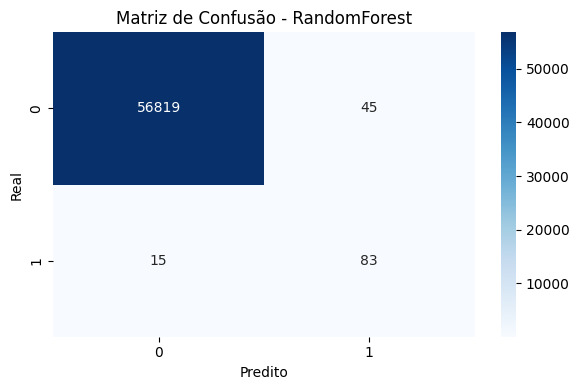

In [41]:
# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - RandomForest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()
gc.collect()

A matriz de confusão demonstra que o modelo Random Forest é eficaz em identificar a maioria dos casos positivos, enquanto mantém uma taxa de erro muito baixa na classe negativa. No entanto, o número de falsos positivos ainda é relativamente alto, o que reduz a precisão na classe 1.

ROC AUC Score: 0.9824


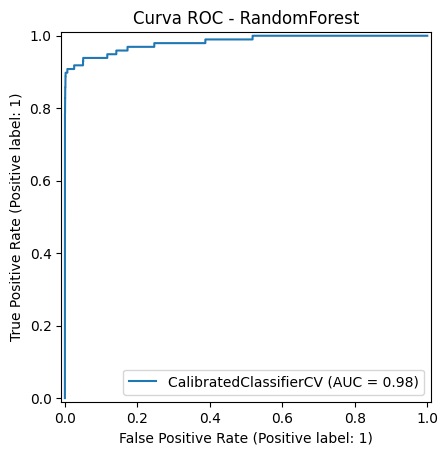

In [42]:

# Curva ROC
roc_auc = roc_auc_score(y_test, y_prob_rf)
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Curva ROC - RandomForest")
plt.show()
gc.collect()

A Curva ROC do modelo Random Forest, com AUC de 0.98, comprova a excelente capacidade preditiva e discriminativa do classificador. Ela reforça os achados já observados na matriz de confusão e no relatório de classificação. O modelo é altamente eficaz na detecção da classe positiva, mesmo em condições de desbalanceamento severo.

In [54]:
scores = cross_val_score(
    estimator=rf_best,
    X=X_train_bal,
    y=y_train_bal,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

print("F1-scores por fold:", scores)
print("F1-score médio:", scores.mean())

F1-scores por fold: [0.99604065 0.99581342 0.99584131]
F1-score médio: 0.995898458612047


# Teste com XGBoost


In [43]:
param_dist_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [44]:

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

In [45]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_bal, y_train_bal)
xgb_best = random_search_xgb.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:09:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [46]:
#Resultados CV
cv_results = pd.DataFrame(random_search_xgb.cv_results_)

# Selecionar apenas algumas colunas úteis
cv_summary = cv_results[[
    'mean_test_score', 'std_test_score', 'rank_test_score', 'params'
]].sort_values(by='rank_test_score')

# Mostrar top 5 melhores combinações e seus scores
print(cv_summary.head())

    mean_test_score  std_test_score  rank_test_score  \
7          0.998847        0.000117                1   
3          0.998154        0.000203                2   
6          0.997603        0.000173                3   
13         0.997341        0.000081                4   
10         0.997209        0.000127                5   

                                               params  
7   {'subsample': 1.0, 'n_estimators': 150, 'max_d...  
3   {'subsample': 1.0, 'n_estimators': 200, 'max_d...  
6   {'subsample': 0.8, 'n_estimators': 100, 'max_d...  
13  {'subsample': 0.8, 'n_estimators': 150, 'max_d...  
10  {'subsample': 1.0, 'n_estimators': 150, 'max_d...  


O modelo XGBoost demonstrou excelente desempenho na validação cruzada, atingindo F1-scores médios superiores a 0.997 em suas melhores configurações. A pequena variação entre os resultados mostra que o algoritmo é robusto, confiável e bem ajustado ao problema, sendo capaz de generalizar bem mesmo em um cenário com classes desbalanceadas. As variações nos parâmetros indicam oportunidades de ajustes finos, mas sem impacto crítico na performance.

In [47]:
xgb_best = random_search_xgb.best_estimator_
xgb_best = CalibratedClassifierCV(estimator=xgb_best, method='sigmoid', cv=5)
xgb_best.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=10, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=150, n_jobs=-1,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

In [48]:
# Avaliação no conjunto de teste
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]

In [49]:
# Relatório
print("Melhores parâmetros:", random_search_xgb.best_params_)
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

Melhores parâmetros: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



O modelo XGBoost demonstrou um desempenho excepcional. O F1-score de 0.86 na classe 1, aliado a um recall de 0.86, evidencia que o modelo está bem ajustado para problemas em que é crucial minimizar falsos negativos sem gerar excesso de falsos positivos — como fraudes, doenças ou falhas operacionais.

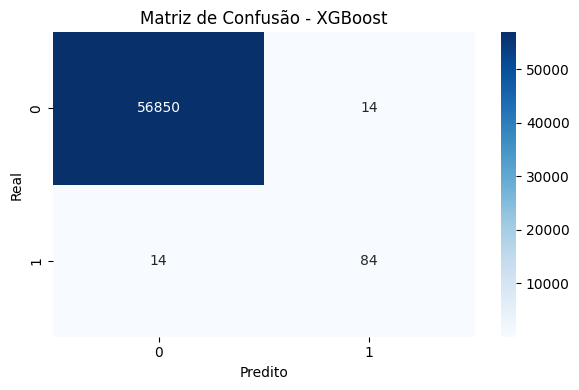

In [50]:
# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - XGBoost")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()
gc.collect()

A matriz de confusão reforça a eficácia do modelo XGBoost, que demonstrou altíssima precisão na classe majoritária e ótima sensibilidade na classe minoritária, mesmo diante de um conjunto de dados com forte desbalanceamento, sendo capaz de detectar eventos importantes sem sobrecarregar o sistema com alarmes falsos.

ROC AUC Score: 0.9813


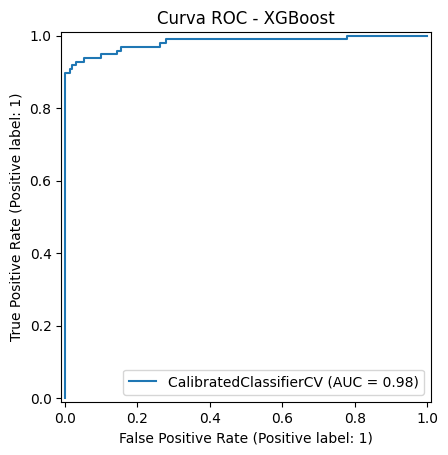

In [51]:
# Curva ROC
roc_auc = roc_auc_score(y_test, y_prob_xgb)
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_estimator(xgb_best, X_test, y_test)
plt.title("Curva ROC - XGBoost")
plt.show()
gc.collect()

A Curva ROC do modelo XGBoost, com AUC de 0.98, confirma sua excelente capacidade de classificação e generalização, mesmo em cenários desafiadores com classes desbalanceadas. Esse resultado valida o modelo como uma solução robusta e eficaz para aplicações práticas, especialmente onde é crucial detectar eventos raros com confiabilidade e equilíbrio.

In [53]:
scores = cross_val_score(
    estimator=xgb_best,
    X=X_train_bal,
    y=y_train_bal,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

print("F1-scores por fold:", scores)
print("F1-score médio:", scores.mean())

F1-scores por fold: [0.99897835 0.99874811 0.99894536]
F1-score médio: 0.9988906031725463


# Considerações finais

Primeiramente irei justificar os mostivos de eu escolher esses 3 modelos. Eu escolhi esses três pois dentre os modelos apresentados em aula, os mais robustos eram SVM, XGBoost e RandomForest, não testei o SVM pois ele necessita de maior poder computacional e é mais sensível que os outros. Em minhas buscas para mitigar o tempo de processamento me deparei com o LGBM e resolvi compara-lo com os demais modelos.

Na comparação entre os modelos Random Forest, XGBoost e LightGBM, todos apresentaram bons resultados, mas com diferenças relevantes tanto em desempenho quanto em eficiência computacional. O Random Forest teve o pior desempenho entre os três, com F1-score de 0.73 na classe minoritária e maior número de falsos positivos (45), embora tenha mantido um bom recall de 85%. O XGBoost foi o modelo com melhores métricas absolutas, alcançando F1-score de 0.86 e recall de 86%, com apenas 14 falsos negativos e 14 falsos positivos, além de AUC de 0.98. No entanto, seu tempo de execução foi muito alto, levando mais de 1h30min para treinar e validar.

Já o LightGBM obteve resultados muito próximos aos do XGBoost — F1-score de 0.85, recall de 87%, e AUC de 0.98 — com desempenho alto. Sua principal vantagem foi a eficiência computacional, concluindo todo o processo de tuning e validação em menos de 15 minutos, com apenas 13 falsos negativos e 16 falsos positivos.

Embora o XGBoost tenha apresentado números ligeiramente superiores, o LightGBM se destaca como o melhor modelo ao oferecer uma performance semelhante com drástica redução no tempo de processamento, tornando-se a opção mais vantajosa para aplicações práticas e ambientes que exigem agilidade e escalabilidade.









**Resultado CV:**


*   LightGBM:

F1-scores por fold: [0.99927503 0.99904464 0.99907755]

F1-score médio: 0.9991324060045423

*   RandomForest

F1-scores por fold: [0.99604065 0.99581342 0.99584131]

F1-score médio: 0.995898458612047

*   XGBoost

F1-scores por fold: [0.99897835 0.99874811 0.99894536]

F1-score médio: 0.9988906031725463




Com base nesses resultados do CV, podemos concluir que o LightGBM foi o modelo com melhor desempenho geral, unindo altíssimo F1-score médio, baixa variabilidade entre os folds, eficiência computacional superior ao XGBoost

Embora o XGBoost também tenha alcançado excelentes resultados, a diferença mínima em F1-score não justifica o maior tempo de execução observado. O RandomForest, por sua vez, mostrou ser competitivo, mas ficou atrás dos modelos de boosting em termos de performance preditiva e tempo de execução.

Portanto, o LightGBM se consolida como a melhor escolha para este projeto, tanto pela qualidade das predições quanto pelo custo computacional, tornando-o ideal para uso em ambientes reais e aplicações que exigem velocidade e precisão.